In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize, interpolate
from scipy import signal
import seaborn as sns
from scipy import stats
import statistics
import matplotlib.patches as patches
import glob
plt.rcParams['pdf.fonttype'] = 42

In [3]:
# データを読みこむ
data_tot = pd.read_csv("./_results.csv")

cells = sorted(data_tot["CellID"].unique().tolist())  # originの細胞を重複なく抜き出す

data_plot = pd.DataFrame({})
for cell in cells:
    df_RFP = data_tot.loc[data_tot["CellID"] == cell, " AverageBrightness(Seg)_C0"]
    df_RFP_sd = data_tot.loc[data_tot["CellID"] == cell, " SD(Cir)_C0"]
    df_RFP_cv = df_RFP_sd/df_RFP
    df_RFP_max = data_tot.loc[data_tot["CellID"] == cell, " MaxValue(Cir)_C0"]
    df_RFP_cv2 = df_RFP_max/df_RFP
    df_FRET = data_tot.loc[data_tot["CellID"] == cell, " AverageBrightness(Seg)_C1"]
    df_CFP = data_tot.loc[data_tot["CellID"] == cell, " AverageBrightness(Seg)_C2"]
    df_ratio = df_FRET / df_CFP
    
    df_RFP_smt = np.convolve(df_RFP, [1, 1, 1], mode="same")/3
    df_RFP_smt[0] = df_RFP_smt[1]
    df_RFP_smt[-1] = df_RFP_smt[-2]
    df_ratio_smt = np.convolve(df_ratio, [1, 1, 1], mode="same")/3
    df_ratio_smt[0] = df_ratio_smt[1]
    df_ratio_smt[-1] = df_ratio_smt[-2]
    
    el_t = [(k-len(df_RFP)+6)*2 for k in range(len(df_CFP))]
    temp = pd.DataFrame([el_t, df_ratio, df_RFP, df_RFP_sd, df_RFP_cv, df_RFP_cv2, df_RFP_max, df_ratio_smt, df_RFP_smt, [cell for i in range(len(df_ratio))]],
                        index=["time", "ratio", "RFP", "RFP_SD", "RFP_cv", "RFP_cv2", "RFP_max", "smt_ratio", "smt_RFP", "cell"])
    data_plot = pd.concat([data_plot, temp.T], ignore_index=True)
data_plot.to_csv("./_data_to_plot_dense-timecourse.csv")
print(data_plot)

       time     ratio        RFP     RFP_SD    RFP_cv   RFP_cv2  RFP_max  \
0    -110.0  1.452472  25.427778  16.288516  0.640580  4.129342    105.0   
1    -108.0  1.348770  23.352941  18.481307  0.791391  5.909320    138.0   
2    -106.0  1.357059  26.775000  18.636841  0.696054  4.444444    119.0   
3    -104.0  1.350523  28.677966  18.330087  0.639170  4.707447    135.0   
4    -102.0  1.360376  28.975155  17.430662  0.601573  4.279528    124.0   
...     ...       ...        ...        ...       ...       ...      ...   
2177    2.0  1.273869  25.696552  16.597882  0.645919  4.942297    127.0   
2178    4.0  1.269504  22.992000  17.006740  0.739681  4.479819    103.0   
2179    6.0  1.323346  22.543750  17.039162  0.755826  7.097311    160.0   
2180    8.0  1.227570  21.722973  16.201563  0.745826  4.327216     94.0   
2181   10.0  1.304480  19.838028  16.367292  0.825046  5.544906    110.0   

      smt_ratio    smt_RFP  cell  
0      1.386100  25.185240   1.0  
1      1.386100  

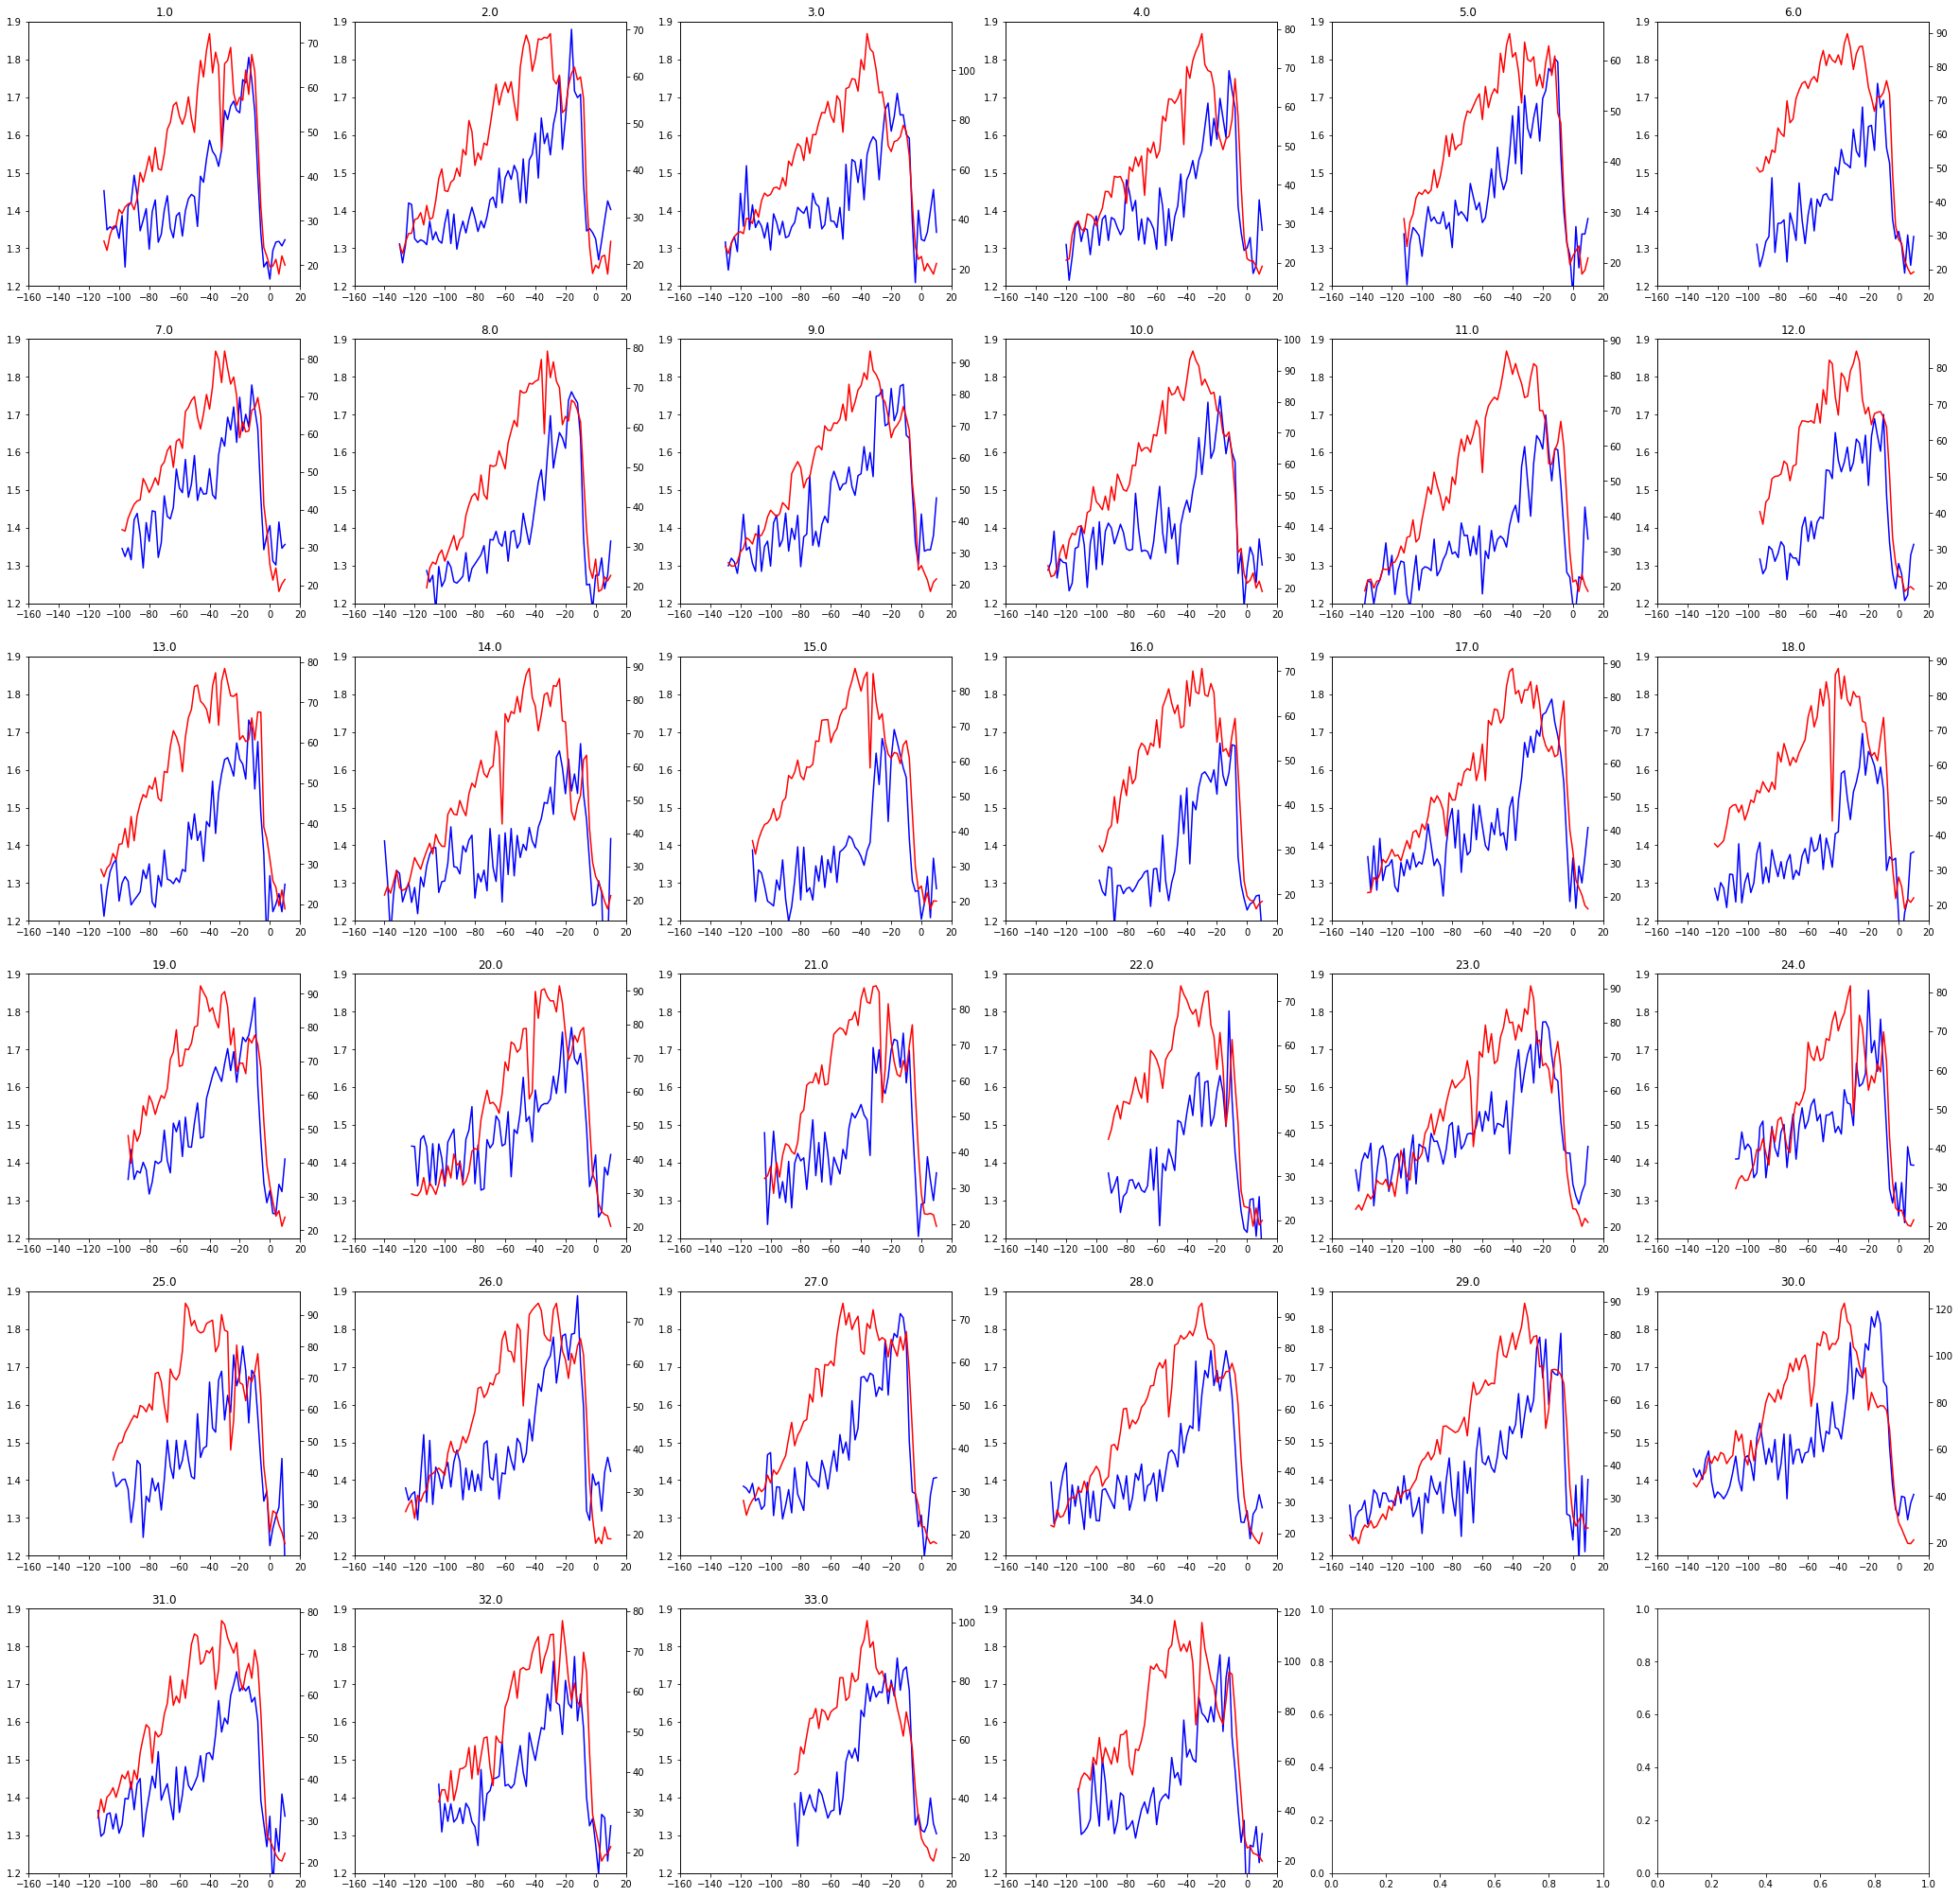

In [4]:
cells = data_plot["cell"].unique().tolist()
n_cell = len(data_plot["cell"].unique().tolist())
ncol=6
nrow=int(n_cell/ncol) + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(6*ncol, 6*nrow))
count = 0
for cell in cells:
    i = int(count/ncol)
    j = count%ncol
    count += 1
    df = data_plot.loc[data_plot["cell"]==cell]
    ax2 = axes[i, j].twinx()
    axes[i, j].plot(df["time"], df["ratio"], color="blue")
    ax2.plot(df["time"], df["RFP"], color="red")
    axes[i, j].set_title(cell)
    axes[i, j].set_xlim([-160, 20])
    axes[i, j].set_ylim([1.2, 1.9])
    

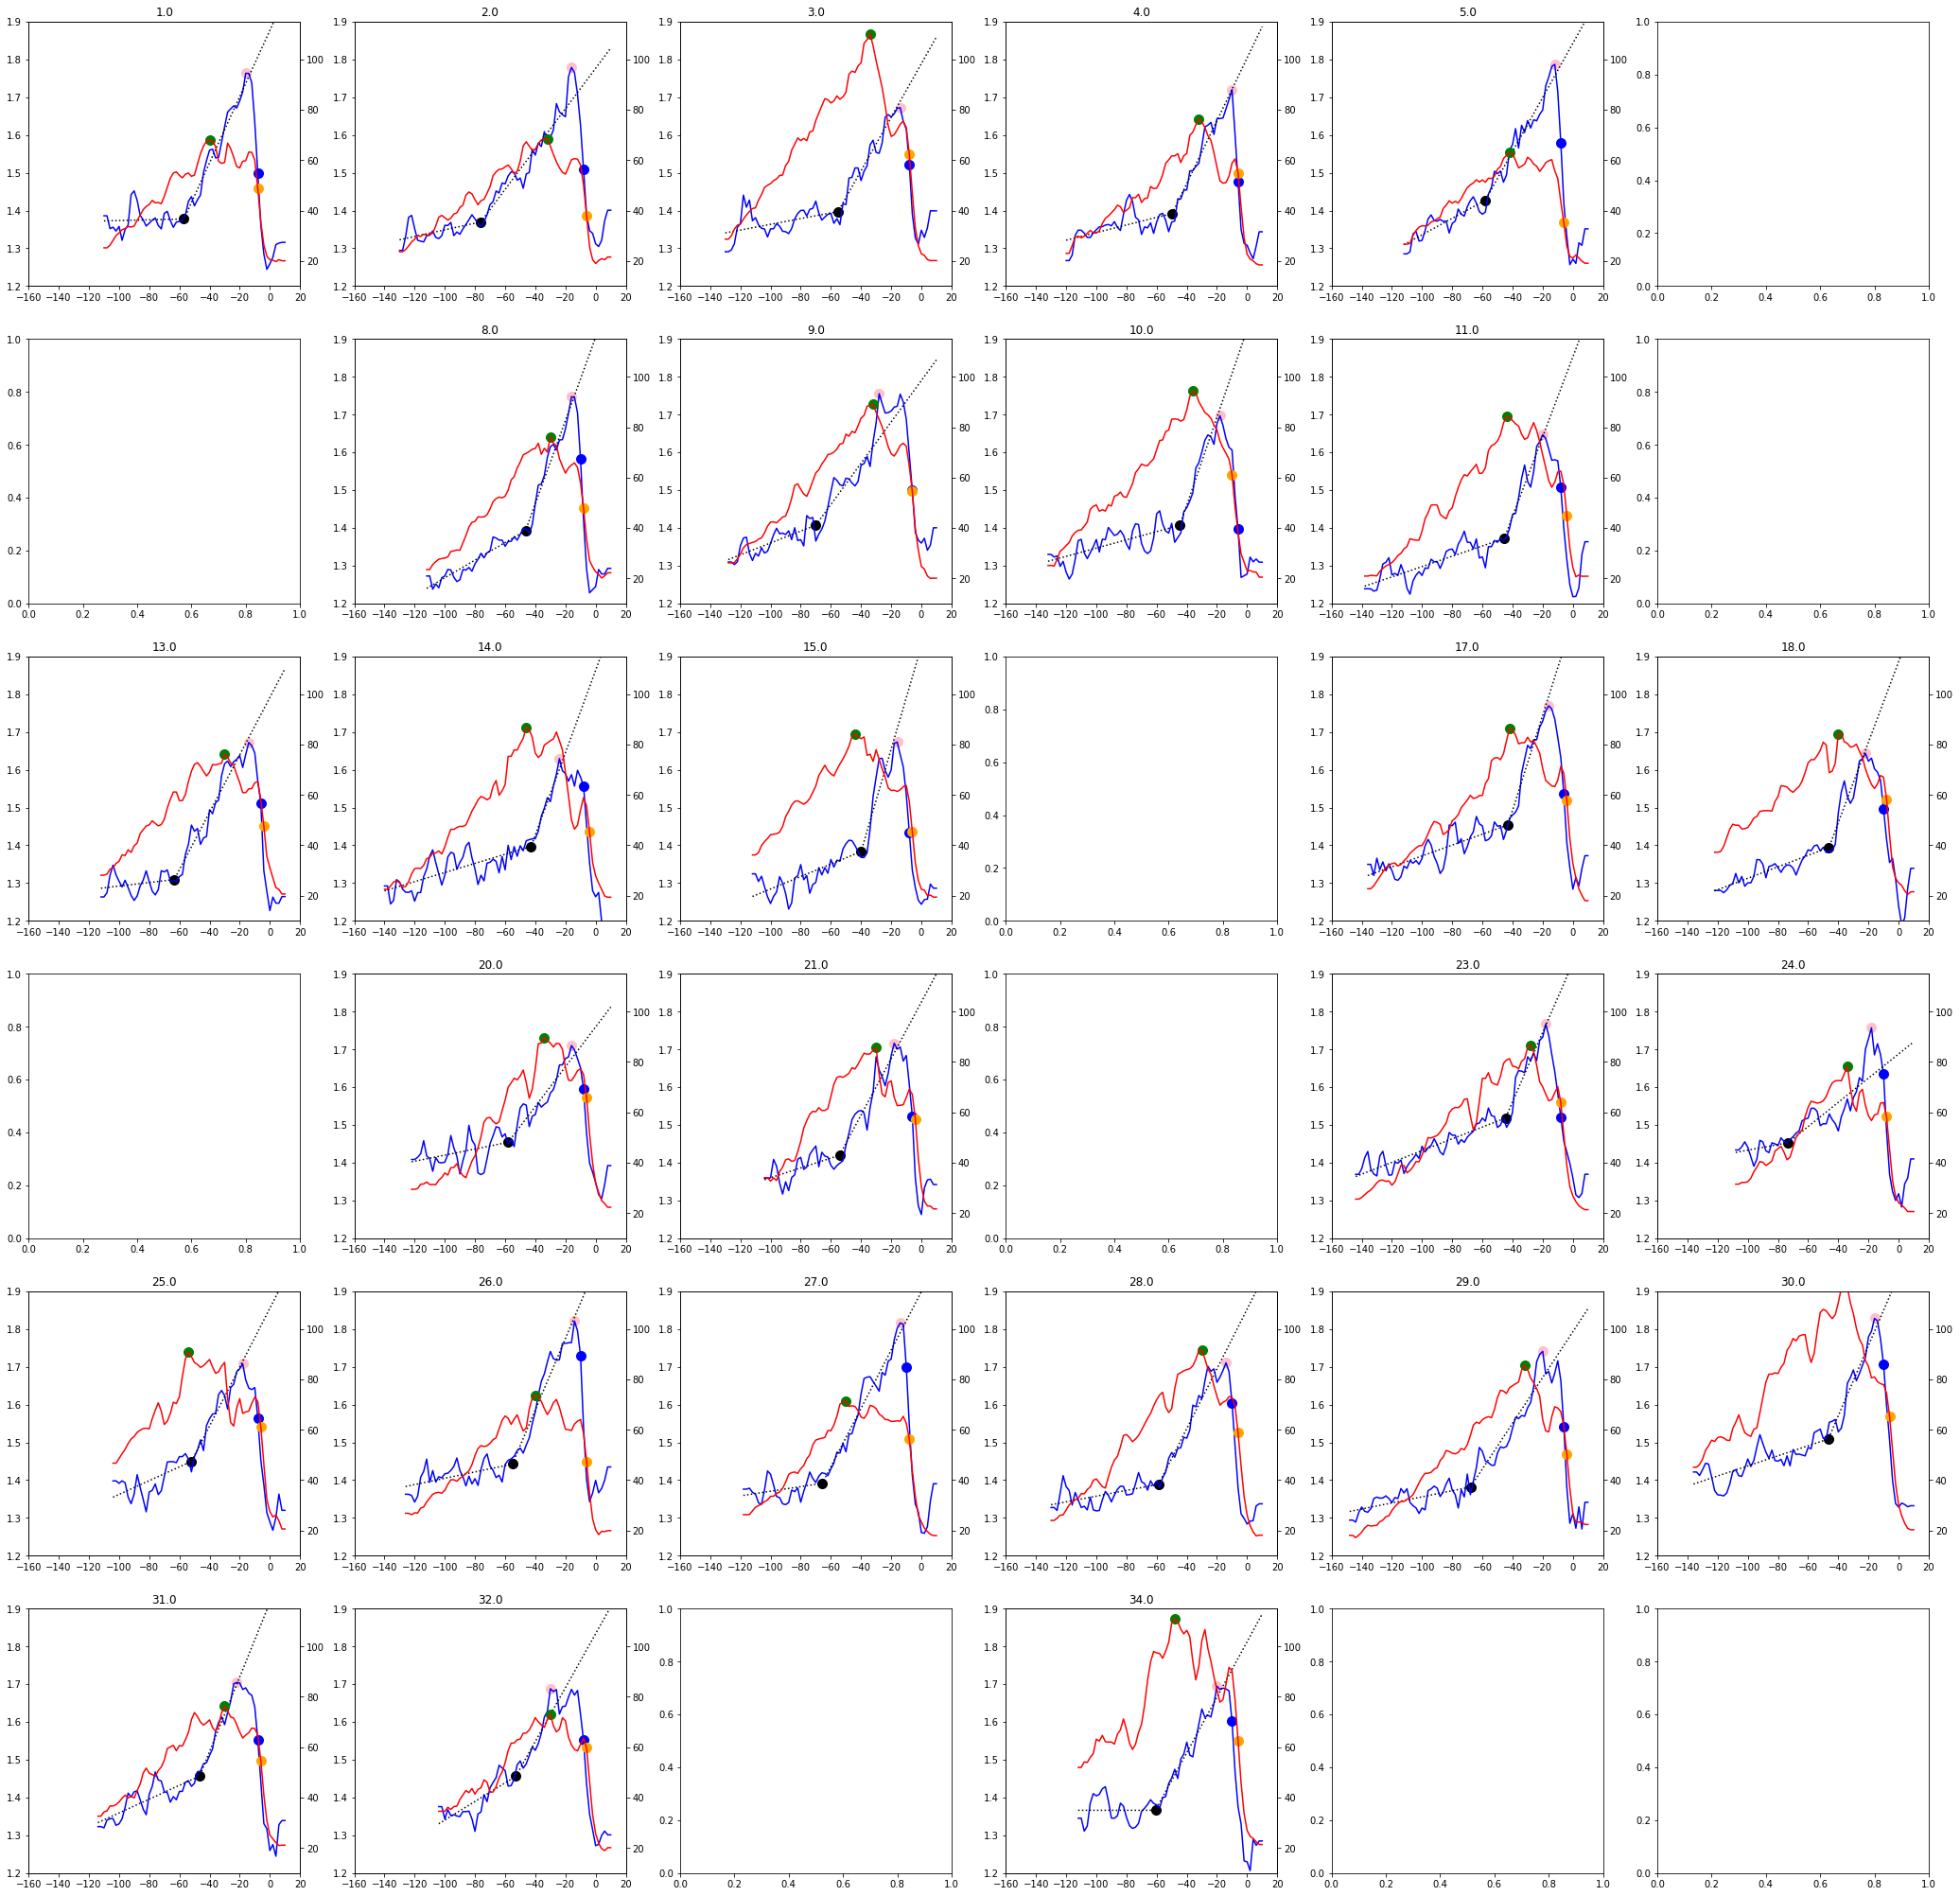

In [5]:
def detect_min_frame(vs):
    diffs = []
    for i in range(len(vs) - 1):
        diffs.append(vs[i+1] - vs[i])
    min_frame = np.argmin(diffs)   # 傾きが一番小さいところ（落ちる直前）
    return min_frame, diffs

def change_point_detection_max_slope(ts, ratios, w=4):
    n_time = len(ts)
    diffs = np.zeros((n_time,))
    for i in range(n_time - w):
        beta, _ = np.polyfit(ts[i:i+w], ratios[i:i+w], deg=1)
        diffs[i] = beta
    frame_change = np.argmax(diffs)
    max_dif = max(diffs)
    med = statistics.median(diffs)
    frame_change2 = np.where(diffs > (med+max_dif)/2)[0][0]
    return frame_change, frame_change2, diffs


#
# piecewise linear regression
#
def piecewise_linear_two_segments(x, x0, y0, b0, b1):
    return np.piecewise(x, [x <= x0, x > x0], [lambda x: b0*(x - x0) + y0, lambda x: b1*(x - x0) + y0])

def initial_guess2(ts):
    rmin = 1.3
    rmax = 1.9
    tmin = ts[0]
    tmax = ts[-1]
    #p0_2 = [0.5*tmin, 1.6, 0., 0.]
    #bounds2 = ([tmin, rmin, 0.0, 0.0], [0, rmax, 0.1, 0.1])
    p0_2 = [0.5*(tmin + tmax), 1.6, 0., 0.]
    bounds2 = ([tmin, rmin, 0.0, 0.0], [tmax, rmax, 0.1, 0.1])
    return p0_2, bounds2

cells = data_plot["cell"].unique().tolist()
cells_to_omit = []
n_cell = len(cells)
ncol=6
nrow=int(n_cell/ncol) + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(6*ncol, 6*nrow))
count = 0
for cell in cells:
    i = int(count/ncol)
    j = count%ncol
    count += 1
    
    if cell in cells_to_omit:
        continue

    df = data_plot.loc[data_plot["cell"] == cell]
    ts = df["time"].tolist()
    rs = df["smt_ratio"].tolist()
    cs = df["smt_RFP"].tolist()

    if ts[0] > -100:
        continue

    min_frame_RFP, _ = detect_min_frame(cs)
    min_frame_ratio, _ = detect_min_frame(rs)
    peak_frame_RFP = np.argmax(cs)
    peak_frame_ratio = np.argmax(rs)
    
    w1 = 0
    w2 = peak_frame_ratio
    
    
    p0_twoseg, bounds_twoseg = initial_guess2(ts[w1:w2])
    p2, _ = optimize.curve_fit(piecewise_linear_two_segments, ts[w1:w2], rs[w1:w2], p0=p0_twoseg, bounds=bounds_twoseg)
    
    cp_seg_ratio = p2[0]
    cp_slope_ratio1, cp_slope_ratio2, _ = change_point_detection_max_slope(ts[w1:w2], rs[w1:w2])

    ax2 = axes[i, j].twinx()
    axes[i, j].plot(ts, rs, color="blue")
    ax2.plot(ts, cs, color="red")
    axes[i, j].plot(ts, piecewise_linear_two_segments(ts, *p2), c='black', ls=":")
    axes[i, j].scatter(p2[0], piecewise_linear_two_segments(p2[0], *p2), s=100, c='black')    
    axes[i, j].scatter(ts[min_frame_ratio], rs[min_frame_ratio], s=100, c='blue')
    ax2.scatter(ts[min_frame_RFP], cs[min_frame_RFP], s=100, c='orange')
    axes[i, j].scatter(ts[peak_frame_ratio], rs[peak_frame_ratio], s=100, c='pink')
    ax2.scatter(ts[peak_frame_RFP], cs[peak_frame_RFP], s=100, c='green')
    axes[i, j].set_title(cell)
    axes[i, j].set_xlim([-160, 20])
    axes[i, j].set_ylim([1.2, 1.9])
    ax2.set_ylim([10, 115])
    

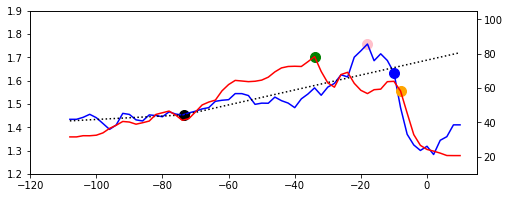

In [6]:
df = data_plot.loc[data_plot["cell"] == 24]
ts = df["time"].tolist()
rs = df["smt_ratio"].tolist()
cs = df["smt_RFP"].tolist()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax2 = ax.twinx()
min_frame_RFP, _ = detect_min_frame(cs)
min_frame_ratio, _ = detect_min_frame(rs)
peak_frame_RFP = np.argmax(cs)
peak_frame_ratio = np.argmax(rs)

w1 = 0
w2 = peak_frame_ratio


p0_twoseg, bounds_twoseg = initial_guess2(ts[w1:w2])
p2, _ = optimize.curve_fit(piecewise_linear_two_segments, ts[w1:w2], rs[w1:w2], p0=p0_twoseg, bounds=bounds_twoseg)

cp_seg_ratio = p2[0]
cp_slope_ratio1, cp_slope_ratio2, _ = change_point_detection_max_slope(ts[w1:w2], rs[w1:w2])

ax.plot(ts, rs, color="blue")
ax2.plot(ts, cs, color="red")
ax.plot(ts, piecewise_linear_two_segments(ts, *p2), c='black', ls=":")
ax.scatter(p2[0], piecewise_linear_two_segments(p2[0], *p2), s=100, c='black')    
ax.scatter(ts[min_frame_ratio], rs[min_frame_ratio], s=100, c='blue')
ax2.scatter(ts[min_frame_RFP], cs[min_frame_RFP], s=100, c='orange')
ax.scatter(ts[peak_frame_ratio], rs[peak_frame_ratio], s=100, c='pink')
ax2.scatter(ts[peak_frame_RFP], cs[peak_frame_RFP], s=100, c='green')

ax.set_xlim([-120, 15])
ax.set_ylim([1.2, 1.9])
ax2.set_ylim([10, 105])
plt.savefig("./_representative.png")
plt.savefig("./_representative.pdf")

In [8]:
cells = data_plot["cell"].unique().tolist()
n_cell = len(cells)

ratio_drops = []
cyclin_drops = []
ratio_peaks = []
cyclin_peaks = []
ratio_cps = []
cells_plt = []
for cell in cells:
    i = int(count/ncol)
    j = count%ncol
    count += 1
    
    if cell in cells_to_omit:
        continue

    df = data_plot.loc[data_plot["cell"] == cell]
    ts = df["time"].tolist()
    rs = df["smt_ratio"].tolist()
    cs = df["smt_RFP"].tolist()

    if ts[0] > -100:
        continue

    min_frame_RFP, _ = detect_min_frame(cs)
    min_frame_ratio, _ = detect_min_frame(rs)
    peak_frame_RFP = np.argmax(cs)
    peak_frame_ratio = np.argmax(rs)
    
    w1 = 0
    w2 = peak_frame_ratio
    
    p0_twoseg, bounds_twoseg = initial_guess2(ts[w1:w2])
    p2, _ = optimize.curve_fit(piecewise_linear_two_segments, ts[w1:w2], rs[w1:w2], p0=p0_twoseg, bounds=bounds_twoseg)
    cp_seg_ratio = p2[0]
    
    cyclin_drops.append(ts[min_frame_RFP])
    ratio_drops.append(ts[min_frame_ratio])
    cyclin_peaks.append(ts[peak_frame_RFP])
    ratio_peaks.append(ts[peak_frame_ratio])
    ratio_cps.append(cp_seg_ratio)
    cells_plt.append(cell)


In [9]:
df_tubulin = pd.read_csv("./tubulin.csv")
print(df_tubulin)
display(df_tubulin.groupby("strain").mean())
display(df_tubulin.groupby("strain").std())
tubu_mean = -18.517241
tubu_std = 2.910826

   strain genotype  stage  strain_num  spindle app  nuc div  duration
0   HS306       WT      2           1            5       23        18
1   HS306       WT      2           1           13       31        18
2   HS306       WT      2           1           23       37        14
3   HS306       WT      2           1           27       53        26
4   HS306       WT      2           1           23       43        20
..    ...      ...    ...         ...          ...      ...       ...
74  HS309   wee1op      4           3           17       31        14
75  HS309   wee1op      4           3           15       32        17
76  HS309   wee1op      4           3           48       58        10
77  HS309   wee1op      4           3           29       45        16
78  HS309   wee1op      4           3           47       61        14

[79 rows x 7 columns]


stage  strain_num  spindle app    nuc div   duration
strain                                                         
HS306   2.310345         1.0    23.482759  42.000000  18.517241
HS307   3.000000         2.0    22.666667  42.458333  19.791667
HS309   2.384615         3.0    25.846154  41.923077  16.076923

stage  strain_num  spindle app    nuc div  duration
strain                                                        
HS306   0.470824         0.0    11.150339  10.430039  2.910826
HS307   0.780189         0.0    10.474261  10.248984  2.888947
HS309   1.168826         0.0    11.605834  11.153199  3.345721

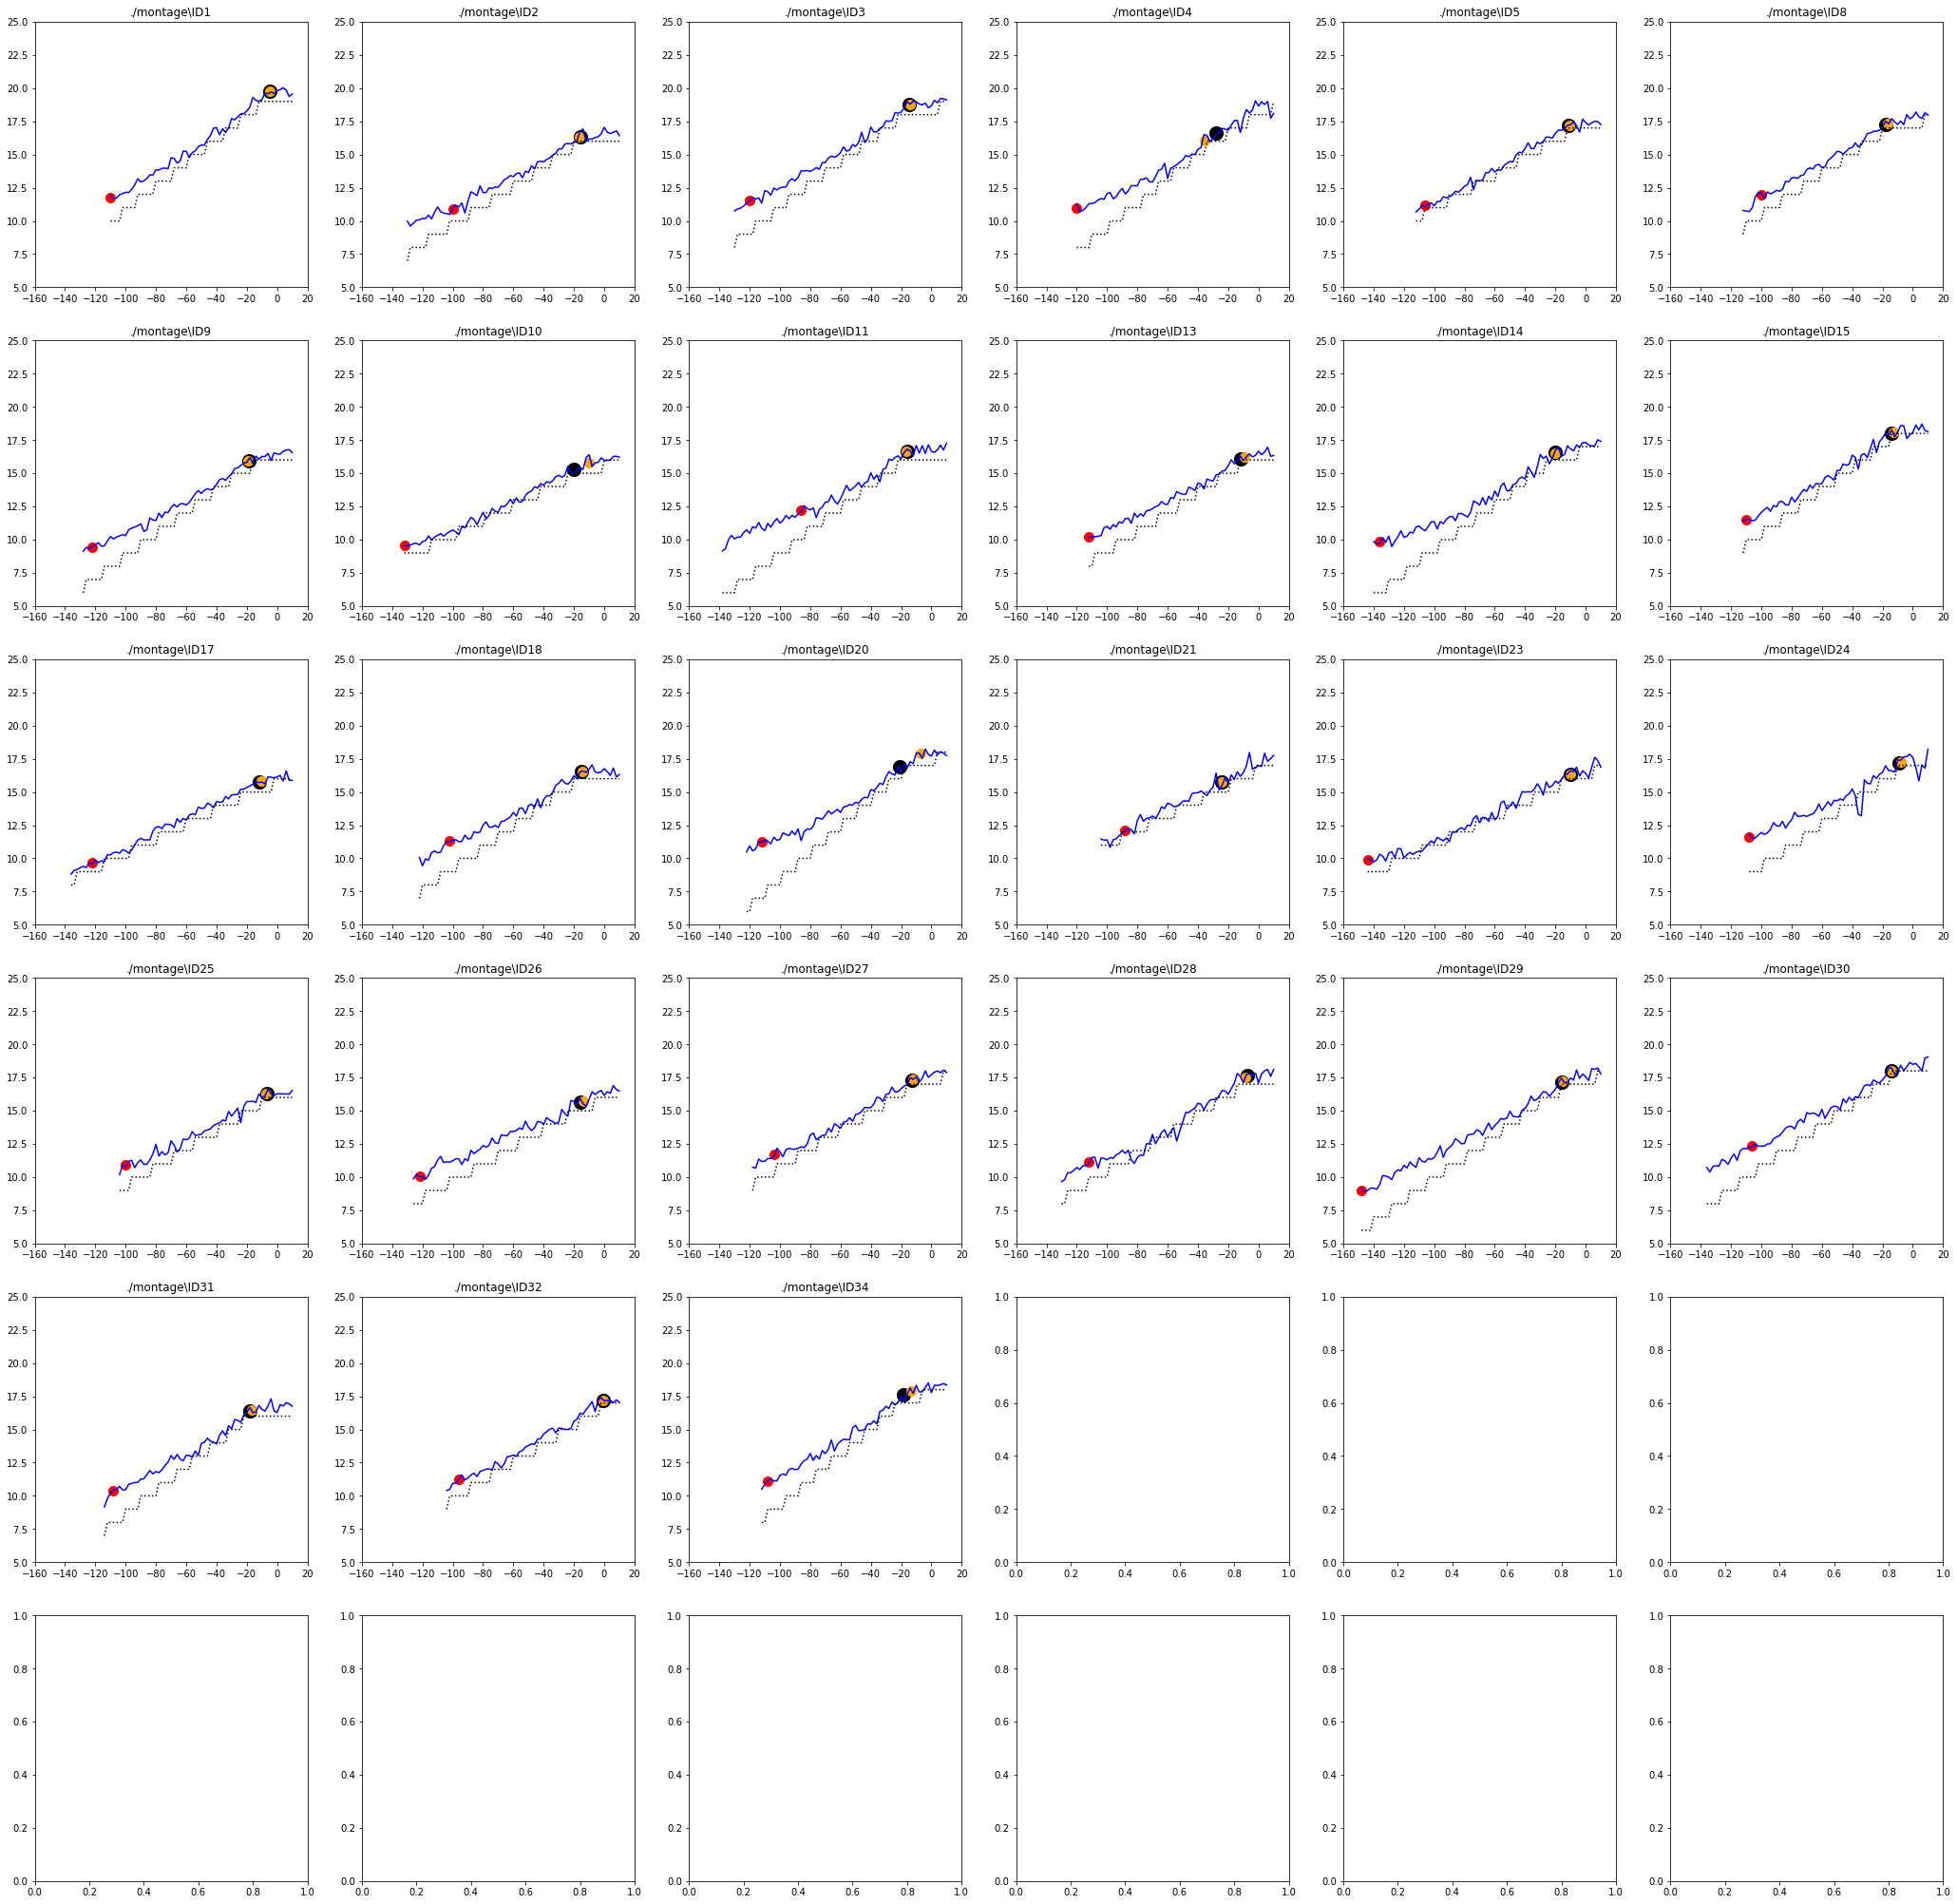

In [14]:
#
# piecewise linear regression
#
def piecewise_linear_two_segments(x, x0, y0, b0, b1):
    return np.piecewise(x, [x <= x0, x > x0], [lambda x: b0*(x - x0) + y0, lambda x: b1*(x - x0) + y0])

def initial_guess2(ts):
    rmin = 0
    rmax = 100
    tmin = ts[0]
    tmax = ts[-1]
    #p0_2 = [0.5*tmin, 1.6, 0., 0.]
    #bounds2 = ([tmin, rmin, 0.0, 0.0], [0, rmax, 0.1, 0.1])
    p0_2 = [0.5*(tmin + tmax), 10, 0., 0.]
    bounds2 = ([tmin, rmin, -1, 0], [tmax, rmax, 5, 0.1])
    return p0_2, bounds2

# 没
def change_point_detection_slope(ts, vs, w=4):
    n_time = len(ts)
    diffs = np.zeros((n_time,))
    for i in range(n_time - w):
        beta, _ = np.polyfit(ts[i:i+w], vs[i:i+w], deg=1)
        diffs[i] = beta
    min_dif = min(diffs)
    med = statistics.median(diffs)
    change_frame = np.where((diffs < med/2) & (diffs > 0))[0][0]
    return change_frame, diffs


IDs = glob.glob("./montage/ID*")
ncol=6
nrow=int(n_cell/ncol) + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(6*ncol, 6*nrow))
count = 0
for ID in IDs:
    cell = ID[12:]
    i = int(count/ncol)
    j = count%ncol
    count += 1

    df_length = pd.read_csv(ID + "/results_len.csv")
    ls = df_length["Length"] / 4.6154
    ls_smt = np.convolve(ls, np.ones(3), mode="same")/3
    ls_smt[0] = ls_smt[1]
    ls_smt[-1] = ls_smt[-2]
    ts = [(k-len(ls)+6)*2 for k in range(len(ls))]
    ts_smt = [(k-len(ls_smt)+6)*2 for k in range(len(ls_smt))]

    w1=-30
    w2=-1
    p0_twoseg, bounds_twoseg = initial_guess2(ts[w1:w2])
    p2, _ = optimize.curve_fit(piecewise_linear_two_segments, ts[w1:w2], ls[w1:w2], p0=p0_twoseg, bounds=bounds_twoseg)

    w1=-30
    w2=-1
    p0_twoseg, bounds_twoseg = initial_guess2(ts_smt[w1:w2])
    p2_2, _ = optimize.curve_fit(piecewise_linear_two_segments, ts_smt[w1:w2], ls_smt[w1:w2], p0=p0_twoseg, bounds=bounds_twoseg)
    
    w1=0
    w2=-1
    CP, _ = change_point_detection_slope(ts_smt[w1:w2], ls_smt[w1:w2])

    axes[i, j].plot(ts, ls, color="blue")
    axes[i, j].plot(ts, piecewise_linear_two_segments(ts, *p2), c='black', ls=":")
    axes[i, j].scatter(p2[0], piecewise_linear_two_segments(p2[0], *p2), s=200, c='black')
    axes[i, j].scatter(p2_2[0], piecewise_linear_two_segments(p2_2[0], *p2_2), s=100, c='orange')
    axes[i, j].scatter(ts_smt[CP], ls_smt[CP], s=100, c='red')
    axes[i, j].set_title(ID)
    axes[i, j].set_xlim([-160, 20])
    axes[i, j].set_ylim([5, 25])

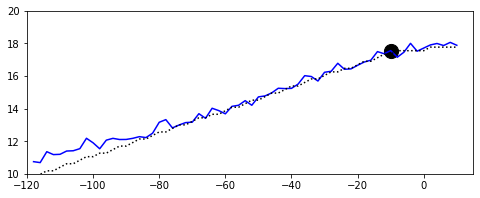

In [20]:
#
# piecewise linear regression
#
def piecewise_linear_two_segments(x, x0, y0, b0, b1):
    return np.piecewise(x, [x <= x0, x > x0], [lambda x: b0*(x - x0) + y0, lambda x: b1*(x - x0) + y0])

def initial_guess2(ts):
    rmin = 0
    rmax = 100
    tmin = ts[0]
    tmax = ts[-1]
    #p0_2 = [0.5*tmin, 1.6, 0., 0.]
    #bounds2 = ([tmin, rmin, 0.0, 0.0], [0, rmax, 0.1, 0.1])
    p0_2 = [0.5*(tmin + tmax), 10, 0., 0.]
    bounds2 = ([tmin, rmin, -1, 0], [tmax, rmax, 5, 0.1])
    return p0_2, bounds2

# 没
def change_point_detection_slope(ts, vs, w=4):
    n_time = len(ts)
    diffs = np.zeros((n_time,))
    for i in range(n_time - w):
        beta, _ = np.polyfit(ts[i:i+w], vs[i:i+w], deg=1)
        diffs[i] = beta
    min_dif = min(diffs)
    med = statistics.median(diffs)
    change_frame = np.where((diffs < med/2) & (diffs > 0))[0][0]
    return change_frame, diffs


IDs = glob.glob("./montage/ID*")
ncol=6
nrow=int(n_cell/ncol) + 1
fig, axes = plt.subplots(1, 1, figsize=(8, 3))

df_length = pd.read_csv("./montage/ID27/results_len.csv")
ls = df_length["Length"]
ls_smt = np.convolve(ls, np.ones(3), mode="same")/3
ls_smt[0] = ls_smt[1]
ls_smt[-1] = ls_smt[-2]
ts = [(k-len(ls)+6)*2 for k in range(len(ls))]
ts_smt = [(k-len(ls_smt)+6)*2 for k in range(len(ls_smt))]

w1=-30
w2=-1
p0_twoseg, bounds_twoseg = initial_guess2(ts[w1:w2])
p2, _ = optimize.curve_fit(piecewise_linear_two_segments, ts[w1:w2], ls[w1:w2], p0=p0_twoseg, bounds=bounds_twoseg)

w1=-30
w2=-1
p0_twoseg, bounds_twoseg = initial_guess2(ts_smt[w1:w2])
p2_2, _ = optimize.curve_fit(piecewise_linear_two_segments, ts_smt[w1:w2], ls_smt[w1:w2], p0=p0_twoseg, bounds=bounds_twoseg)

w1=0
w2=-1
CP, _ = change_point_detection_slope(ts_smt[w1:w2], ls_smt[w1:w2])

axes.plot(ts, ls/4.6154, color="blue")
axes.plot(ts, piecewise_linear_two_segments(ts, *p2)/4.6154, c='black', ls=":")
axes.scatter(p2[0], piecewise_linear_two_segments(p2[0], *p2)/4.6154, s=200, c='black')
axes.set_xlim([-120, 15])
axes.set_ylim([10, 20])
plt.savefig("./_length_representative.png")
plt.savefig("./_length_representative.pdf")

In [11]:
#
# piecewise linear regression
#
def piecewise_linear_two_segments(x, x0, y0, b0, b1):
    return np.piecewise(x, [x <= x0, x > x0], [lambda x: b0*(x - x0) + y0, lambda x: b1*(x - x0) + y0])

def initial_guess2(ts):
    rmin = 0
    rmax = 100
    tmin = ts[0]
    tmax = ts[-1]
    #p0_2 = [0.5*tmin, 1.6, 0., 0.]
    #bounds2 = ([tmin, rmin, 0.0, 0.0], [0, rmax, 0.1, 0.1])
    p0_2 = [0.5*(tmin + tmax), 10, 0., 0.]
    bounds2 = ([tmin, rmin, -1, 0], [tmax, rmax, 5, 0.1])
    return p0_2, bounds2

# 没
def change_point_detection_slope(ts, vs, w=4):
    n_time = len(ts)
    diffs = np.zeros((n_time,))
    for i in range(n_time - w):
        beta, _ = np.polyfit(ts[i:i+w], vs[i:i+w], deg=1)
        diffs[i] = beta
    min_dif = min(diffs)
    med = statistics.median(diffs)
    change_frame = np.where((diffs < med/2) & (diffs > 0))[0][0]
    return change_frame, diffs


IDs = glob.glob("./montage/ID*")
CPs_len = []
for ID in IDs:
    cell = ID[12:]

    df_length = pd.read_csv(ID + "/results_len.csv")
    ls = df_length["Length"]
    ts = [(k-len(ls)+6)*2 for k in range(len(ls))]

    w1=-30
    w2=-1
    p0_twoseg, bounds_twoseg = initial_guess2(ts[w1:w2])
    p2, _ = optimize.curve_fit(piecewise_linear_two_segments, ts[w1:w2], ls[w1:w2], p0=p0_twoseg, bounds=bounds_twoseg)
    CPs_len.append(p2[0])


In [14]:
df_time_plot = pd.DataFrame({})
df_time_plot["cyclin_drop"] = cyclin_drops
df_time_plot["ratio_drop"] = ratio_drops
df_time_plot["cyclin_peak"] = cyclin_peaks
df_time_plot["ratio_peak"] = ratio_peaks
df_time_plot["ratio_cp"] = ratio_cps
df_time_plot["length_cp"] = CPs_len
df_time_plot["cell"] = cells_plt
df_time_plot = pd.merge(df_tubulin.loc[df_tubulin["strain"]=="HS306", ["duration"]]*(-1), df_time_plot, right_index=True, left_index=True, how="outer")
print(len(df_tubulin.loc[df_tubulin["strain"]=="HS306", ["duration"]]*(-1)))
display(df_time_plot)
df_time_plot_melt = pd.melt(df_time_plot, id_vars=["cell"], value_vars=["cyclin_drop", "ratio_drop", "length_cp", "ratio_peak", "duration", "cyclin_peak", "ratio_cp"])
#df_time_plot_melt = pd.melt(df_time_plot, id_vars=["cell"], value_vars=["cyclin_drop", "ratio_drop", "ratio_peak", "cyclin_peak", "ratio_cp"])
display(df_time_plot_melt)

29


duration  cyclin_drop  ratio_drop  cyclin_peak  ratio_peak   ratio_cp  \
0        -18         -8.0        -8.0        -40.0       -16.0 -56.966603   
1        -18         -6.0        -8.0        -32.0       -16.0 -76.131032   
2        -14         -8.0        -8.0        -34.0       -14.0 -55.242045   
3        -26         -6.0        -6.0        -32.0       -10.0 -49.555721   
4        -20         -6.0        -8.0        -42.0       -12.0 -58.000000   
5        -15         -8.0       -10.0        -30.0       -16.0 -46.472606   
6        -18         -6.0        -6.0        -32.0       -28.0 -69.999984   
7        -20        -10.0        -6.0        -36.0       -18.0 -44.623524   
8        -18         -4.0        -8.0        -44.0       -20.0 -45.478832   
9        -21         -4.0        -6.0        -30.0       -14.0 -63.403836   
10       -19         -4.0        -8.0        -46.0       -24.0 -42.763101   
11       -18         -6.0        -8.0        -44.0       -16.0 -39.976654   
12       -16         -4.0        -6.0        -42.0       -16.0 -43.068746   
13       -18         -8.0       -10.0        -40.0       -22.0 -46.185425   
14       -19         -6.0        -8.0        -34.0       -16.0 -58.000062   
15       -21         -4.0        -6.0        -30.0       -18.0 -54.240727   
16       -15         -8.0        -8.0        -28.0       -18.0 -44.657465   
17       -21         -8.0       -10.0        -34.0       -18.0 -73.405519   
18       -23         -6.0        -8.0        -54.0       -18.0 -52.000016   
19       -22         -6.0       -10.0        -40.0       -14.0 -55.191601   
20       -19         -8.0       -10.0        -50.0       -14.0 -65.679082   
21       -17         -6.0       -10.0        -30.0       -14.0 -58.692729   
22       -19         -4.0        -6.0        -32.0       -20.0 -67.878625   
23       -14         -6.0       -10.0        -36.0       -16.0 -46.623111   
24       -12         -6.0        -8.0        -30.0       -22.0 -46.561437   
25       -18         -6.0        -8.0        -30.0       -30.0 -52.886050   
26       -21         -6.0       -10.0        -48.0       -20.0 -60.747646   
27       -18          NaN         NaN          NaN         NaN        NaN   
28       -19          NaN         NaN          NaN         NaN        NaN   

    length_cp  cell  
0   -4.812752   1.0  
1  -16.000001   2.0  
2  -14.544985   3.0  
3   -0.873328   4.0  
4  -11.078016   5.0  
5  -15.463399   8.0  
6  -17.980797   9.0  
7  -10.000001  10.0  
8  -16.000025  11.0  
9  -10.207098  13.0  
10 -18.553267  14.0  
11 -13.999999  15.0  
12 -10.802225  17.0  
13 -14.804879  18.0  
14  -8.130799  20.0  
15   4.000001  21.0  
16  -6.458576  23.0  
17  -8.798120  24.0  
18  -6.918386  25.0  
19  -4.000003  26.0  
20  -9.847690  27.0  
21  -7.093915  28.0  
22 -10.253791  29.0  
23 -14.000000  30.0  
24 -17.978922  31.0  
25  -0.677212  32.0  
26 -14.000000  34.0  
27        NaN   NaN  
28        NaN   NaN

cell     variable      value
0     1.0  cyclin_drop  -8.000000
1     2.0  cyclin_drop  -6.000000
2     3.0  cyclin_drop  -8.000000
3     4.0  cyclin_drop  -6.000000
4     5.0  cyclin_drop  -6.000000
..    ...          ...        ...
198  31.0     ratio_cp -46.561437
199  32.0     ratio_cp -52.886050
200  34.0     ratio_cp -60.747646
201   NaN     ratio_cp        NaN
202   NaN     ratio_cp        NaN

[203 rows x 3 columns]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 13.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


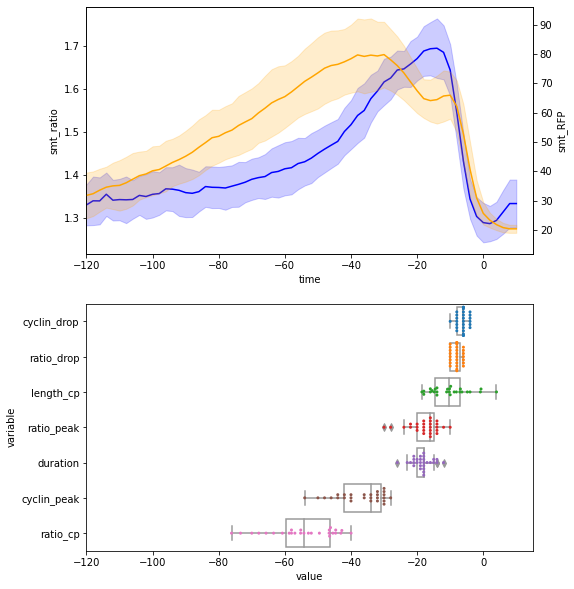

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
ax2 = axes[0].twinx()
sns.lineplot(x="time", y="smt_ratio", data=data_plot, ci="sd", color="blue", ax=axes[0])
sns.lineplot(x="time", y="smt_RFP", data=data_plot, ci="sd", color="orange", ax=ax2)
sns.swarmplot(x="value", y="variable", data=df_time_plot_melt, ax=axes[1], s=3)
sns.boxplot(x="value", y="variable", data=df_time_plot_melt, ax=axes[1], color="white")
#r = patches.Rectangle(xy=(tubu_mean-tubu_std, 1.2), width=tubu_std*2, height=0.6, ec="black", fc="black", fill=True, alpha=0.3)
#axes[0].add_patch(r)
#r = patches.Rectangle(xy=(tubu_mean-tubu_std, -10), width=tubu_std*2, height=100, ec="black", fc="black", fill=True, alpha=0.3)
#axes[1].add_patch(r)
axes[0].set_xlim([-120, 15])
axes[1].set_xlim([-120, 15])
plt.savefig("./_timecourse-and-event_box.png")
plt.savefig("./_timecourse-and-event_box.pdf")

In [20]:
display(df_time_plot_melt.groupby("variable").mean())

cell      value
variable                         
cyclin_drop  17.777778  -6.222222
cyclin_peak  17.777778 -37.037037
duration     17.777778 -18.517241
length_cp    17.777778 -10.343636
ratio_cp     17.777778 -54.608599
ratio_drop   17.777778  -8.074074
ratio_peak   17.777778 -17.777778

In [21]:
display(df_time_plot_melt.groupby("variable").std())

cell     value
variable                        
cyclin_drop  10.251954  1.601282
cyclin_peak  10.251954  7.176251
duration     10.251954  2.910826
length_cp    10.251954  5.742538
ratio_cp     10.251954  9.968947
ratio_drop   10.251954  1.517232
ratio_peak   10.251954  4.517771

In [22]:
display(df_time_plot_melt.groupby("variable").median())

cell      value
variable                    
cyclin_drop  18.0  -6.000000
cyclin_peak  18.0 -34.000000
duration     18.0 -18.000000
length_cp    18.0 -10.253791
ratio_cp     18.0 -54.240727
ratio_drop   18.0  -8.000000
ratio_peak   18.0 -16.000000